In [399]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.datasets import mnist
from tqdm import tqdm

In [376]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [377]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

In [378]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


In [53]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size=20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self, item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

## 【問題1】重みの初期値を決めるコードの作成
ニューラルネットワークの学習はフォワードプロパゲーションとバックプロパゲーションの繰り返しになります。

## 【問題2】フォワードプロパゲーションの実装

## 【問題3】交差エントロピー誤差の実装

## 【問題4】バックプロパゲーションの実装

## 【問題5】推定

In [412]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    def __init__(self, epoch=10, eta=0.001, verbose = True):
        n_features = 784
        n_nodes1 = 400
        n_nodes2 = 200
        n_nodes3 = 10
        sigma = 0.01
        self.W1 = sigma * np.random.randn(n_features, n_nodes1)
        self.b1 = sigma * np.random.randn(n_nodes1)
        self.W2 = sigma * np.random.randn(n_nodes1, n_nodes2)
        self.b2 = sigma * np.random.randn(n_nodes2)
        self.W3 = sigma * np.random.randn(n_nodes2, n_nodes3)
        self.b3 = sigma * np.random.randn(n_nodes3)
        self.loss_train = []
        self.loss_valid = []
        self.epoch = epoch
        self.eta = eta
        self.verbose = verbose

    def fit(self, X, y, X_val=None, y_val=None):
        """
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
        for _ in tqdm(range(self.epoch)):
            for mini_X_train, mini_y_train in get_mini_batch:
                self.feedforward(mini_X_train)
                self.backprop(mini_X_train, mini_y_train)
    
            self.loss_train.append(self.crossentropy(mini_y_train, self.y_hat))
            if X_val is not None:
                y_val_pred = np.dot(self.tanh(np.dot(self.tanh(np.dot(X_val, self.W1)+self.b1), self.W2)+self.b2), self.W3)+self.b3
                y_val_pred = self.softmax(y_val_pred)
                self.loss_valid.append(self.crossentropy(y_val, y_val_pred))
           
        
    def feedforward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = self.tanh(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = self.tanh(self.Z2)
        self.Z3 = np.dot(self.A2, self.W3) + self.b3
        self.y_hat = self.softmax(self.Z3)
        
        
    def backprop(self, X, y):
        dZ3 = self.y_hat - y
        db3 = np.sum(dZ3, axis=0)
        dW3 = np.dot(self.A2.T, dZ3)
        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = (1-self.tanh(self.Z2)**2) * dA2
        db2 = np.sum(dZ2, axis=0)
        dW2 = np.dot(self.A1.T, dZ2)
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = (1-self.tanh(self.Z1)**2) * dA1
        db1 = np.sum(dZ1, axis=0)
        dW1 = np.dot(X.T, dZ1)
        
        self.b3 -= self.eta*db3
        self.W3 -= self.eta*dW3
        self.b2 -= self.eta*db2
        self.W2 -= self.eta*dW2
        self.b1 -= self.eta*db1
        self.W1 -= self.eta*dW1
        
    
    def sigmoid(self, Z):
        return (1 + np.exp(-Z)) ** (-1)
     
    def tanh(self, Z):
        return np.tanh(Z)
    
    def softmax(self, x):
        if x.ndim == 2:
            x = x.T
            x = x - np.max(x, axis=0)
            y = np.exp(x) / np.sum(np.exp(x), axis=0)
            return y.T
        x = x - np.max(x)   # オーバーフロー対策
        return np.exp(x) / np.sum(np.exp(x))
#     def softmax(self, Z):
#         return np.exp(Z)/np.sum(np.exp(Z), axis=0)
    
    def crossentropy(self, y, y_pred):
        loss = -np.mean(np.sum(y*np.log(y_pred), axis=1))
        return loss
    
    
    def predict(self, X_test):
        a1 = self.tanh(np.dot(X_test, self.W1)+self.b1)
        a2 = self.tanh(np.dot(a1, self.W2)+self.b2)
        y_pred = np.argmax(np.dot(a2, self.W3)+self.b3, axis=1)
        return y_pred

## 【問題6】学習と推定

## 【問題7】学習曲線のプロット

In [416]:
nn = ScratchSimpleNeuralNetrowkClassifier(epoch=50)
nn.fit(X_train, y_train, X_val=X_val, y_val=y_val)

100%|██████████| 50/50 [06:15<00:00,  7.51s/it]


In [431]:
y_pred = nn.predict(X_val)
accuracy_score(y_pred, np.argmax(y_val, axis=1))

0.9770833333333333

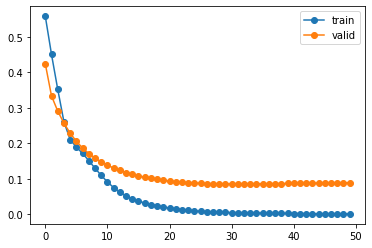

In [432]:
plt.plot(nn.loss_train, '-o', label='train')
plt.plot(nn.loss_valid, '-o', label='valid')
plt.legend();

## 【問題8】誤分類の確認

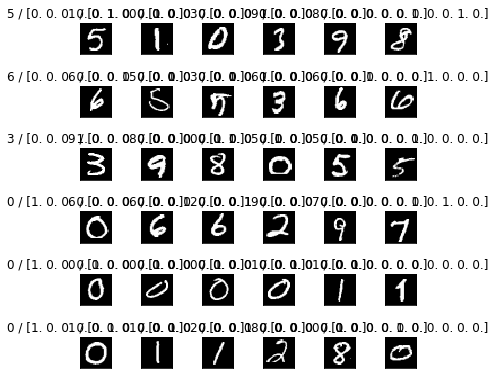

In [444]:
import pandas as pd
num = 36 # いくつ表示するか
#true_false = pd.get_dummies(y_pred).values==y_val
true_false = y_pred==np.argmax(y_val)
false_list = np.where(true_false==False)[0].astype(np.int)
if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')